# Tutorial for *CYCLUS*: Nuclear Fuel Cycle Simulator 

<img src="img/cyclus_img.gif" width="400">
## [*CYCLUS*](http://fuelcycle.org/) Introduction
*CYCLUS* is an open source nuclear fuel cycle simulation platform whose  genesis was driven by a variety of gaps seen in previous fuel cycle simulation efforts, which attempted to address three major design and development philosophies:
- A desire for usability, thus developing a tool which begins with a simple model in a visual development environment that aims to provide an intuitive user interface
- A desire for rapid prototyping, thus developing a tool which begins with simple models in a scripting language that allows for quick answers to early problems 
- A desire for detail/fidelity, thus developing a tool with an ad-hoc combination of existing complex analysis tools 

http://fuelcycle.org/basics/index.html


## Fundamental Concepts in Cyclus
Several fundamental concepts are deeply engrained in the Cyclus kernel, and understanding them is important for users and developers of Cyclus.

The following concepts are defined in more detail below:
   - Cyclus is an agent-based simulation
   - agents are either regions, institutions, or facilities
   - Cyclus tracks the evolution of a system over time
   - agents interact through a dynamic resource exchange that is recomputed at each time step
   - Cyclus catalogs the transactions of discrete quanta of resources
   - agents may enter or leave the simulation over the lifetime of a simulation
   - each agent is deployed as a clone of a prototype
   - each prototype is defined as a configuration an archetype
   - archetypes are loaded dynamically at runtime and can be contributed by any user/developer

### Agent-Simulation

A Cyclus simulation models a system of discrete agents that interact to exchange resources. Most of the behavior of a Cyclus simulation is the result of the interaction among a set of individual and nominally independent agents. By using an agent-based
framework, *CYCLUS* tracks the transformation
and trade of resources between autonomous regional
and institutional entities with customizable behav-
ior and objectives.  

### Region, Institution, Facility Hierarchy¶
The primary agent interaction is among Facility agents, each representing a single discrete nuclear fuel cycle facility.

Each Facility agent is owned/operated by an Institution agent, representing a legal operating organization such as a utility, government, non-governmental organization, etc. Institution agents are responsible for deploying and decommissioning Facility agents.

Each Institution operates in a Region agent, representing a geopolitical region such as a nation-state, sub-national state, super-national region, etc. Region agents are responsible for requesting the deployment of additional Facilities through their Institutions.

Institution and Region agents can alter the way that their Facility agents interact with other Facility agents.
Through the use of agents and its user-customizable archetypes (called prototypes), cyclus  allows for freedom in fidelity, depth, and focus of the simulation.

### Tracking the Fuel Cycle Over Time¶

A Cyclus simulation marches through time with a fixed time step. At each time step, the system itself may change and the dynamic resource exchange is recomputed.

### Agent Deployment and Decommissioning¶

Facility agents can be deployed or decommissioned at each time step, changing the system that is being modeled through the dynamic resource exchange. The decision of when to deploy new facility agents and which agents to deploy is made by the institution agents based on user input. Agents may be decommissioned either because they reach their lifetime or because a decision to decommission is made by the institution that operates them.
### Agent Prototypes¶
Each agent in the simulation is deployed as a clone of a prototype. A prototype is formed by adding user-defined configuration details to an archetype.
### Agent Archetypes
Agent archetypes define the logic that governs the behavior of an agent. An archetype may allow a user to define some parameters that influence that behavior. Broadly speaking, the behavior of an agent can be divided into the behavior that represents the physical models of the system and the behavior that represents the interaction of the agent with other agents.
### Run-time Discovery and Loading of Archetypes
To maximize the flexibility of the Cyclus infrastructure, is has been designed to allow the addition of new archetypes without having to make any changes to the Cyclus kernel. Therefore, the kernel has no prior knowledge of archetypes or their behavior other than how they are deployed/decommissioned and how they interact with the dynamic resource exchange. For this reason, every Cyclus simulation must find and load the archetypes requested by the user.


### Dynamic Resource Exchange¶
Facility agents interact through the dynamic resource exchange by submitting requests for resources and/or receiving bids to provide those resources. All facilities that request resources can then establish their preferences across the set of bids they receive and the global set of preferences is used to resolve the exchange by maximizing the global preference.

### Discrete Resource Tracking¶
The outcome of the dynamic resource exchange is a set of transactions of discrete resources, with specific quantities and identities, between specific facility agents. These discrete resources can be tracked through their life cycle by their identities.

## Cycamore

Cycamore, the *CYCLUS* additional module repository, provides a fundamental set of dynamically loadable libraries providing agent archetypes for basic simulation functionality within *CYCLUS*. Since *CYCLUS* relies on external archetypes to represent the agents within a  simulation, Cycamore provides  the  basic archetypes a new user needs to get started running simple simulations. These archetypes support a minimal set of fuel cycle simulation goals and provide, by example, a guide to new developers who would seek to contribute their own archetypes such as *Cyborg*, *Brightlite*, and *Recycle*, outside of Cycamore. 


## ❖ **Learning Objectives**
### 1.  Learn the principles of *CYCLUS* input files
### 2.  Write a *CYCLUS* input file 
### 3.  Use *CYCLUS* to simulate your input file
### 4.  Utilize cyutils (*CYCLUS* analysis package) to analyze the *CYCLUS* output file


# Table of contents
- How to build a *CYCLUS* input file
    - Simulation Control
    - Fuel Composition
    - Region
    - Reactor
    - Main Input 
- Exercise 1: Writing the Input file 
    - Simulation Control
    - Fuel Composition
    - Region
    - Reactor
    - Main Input 
- Exercise 2: Running the *CYCLUS* simulation

# How to build a *CYCLUS* input file

This tutorial will begin with a simple exercise using Cycamore archetypes to familiarize the user with [creating input files](http://fuelcycle.org/user/writing_input.html) (in xml) and accessing data from the SQLite database output. 
    

## Structure of a *CYCLUS* input file
In a *CYCLUS* input file, although not all sections are required, the following sections may appear in any order in the input file:

 - Control - Simulation Control (required once)
 - Commodity - Commodity Priority (optional, may appear multiple times)
 - Archetype - List of available agent archetypes (required once)
 - Facility - Facility Prototypes (at least one required)
 - Region - Region agents (at least one required)
 - Institution - Institution agents (at least one required in each Region)
 - Recipe - Recipe Definition (optional, may appear multiple times)


### Simulation Control:
Simulation control are parameters that set duration, start month, start year, and decay of the simulation. 
*CYCLUS* works in timesteps of 1 month by default. At each time step, *CYCLUS* implements  an  agent-based  modeling
paradigm, in which each agent can take particular actions such as:
-  [Deployment](http://fuelcycle.org/basics/concepts.html?highlight=deployed#agent-deployment-and-decommissioning): New agents enter the fuel cycle
-  An agent prepares for material exchange
-  The material trade between two agents occurs
-  The agents use material after the exchange
-  [Decommissioning](http://fuelcycle.org/basics/concepts.html?highlight=decommissioned#agent-deployment-and-decommissioning): Agents leave the fuel cycle
<br>

*CYCLUS* will manage these interactions automatically, but the user must give:
-  The duration (in months)
-  The start month (e.g.: 1 for January)
-  The start year
-  [Decay](http://fuelcycle.org/devdoc/decay.html): The Cyclus kernel has built-in experimental support for decay calculations.  Materials store the time since their last decay and agents are free to invoke the decay function on them as desired to decay them to the current simulation time. Cyclus can operate in 3 decay modes, with 1 additional mode likely to be added in a future release:  
     - 'never' if all decay is turned off 
     - 'manual', meaning it is only on if the individual archetype decays their own inventory
     - lazy', which will compute decay only when archetypes fetch a particular composition.
     - 'periodic'  (future)  automatically  decays  all materials in a simulation with some fixed frequency.
<br>

There are other [optional parameters](http://fuelcycle.org/user/input_specs/control.html) that could be given.

An example of a basic Simulation Control XML file is given below where the `startyear` is 2007, the `startmonth` is 11 (November), `duration` is 1200 (1200 months, 100 years), the length of a `timestep` is 1 day, and `decay` is set to lazy. <img src="img/sim_control.png" width="500">


### Region-Instituion-Facility hierarchy

Region-Instituion-Facility hierarchy (RIF) is the fundamental order of responsibility and tranactions that occur in a *CYCLUS* simulation. In other words, RIF hierarchies form a
directed acyclic graph (DAG)
, with regions as root
nodes and facilities as leaf nodes.
<img src="img/RIF.png" width="500">


For instance, one may wish to account for the presence of a contract between two facilities, or one may wish to model two facilities oper-
ated by the same entity. Accordingly, *CYCLUS*
implements this ability via a Region-Instituion-Facility hierarchy. Every
discrete facility in *CYCLUS* is considered to be owned by an
institution that operates in a geographic region. An institution
can be used to represent any entity that may own and operate a
facility such as a private corporation, a government agency, or
a non-governmental organization, among others. A region can
be used to represent any geographic area, typically a politically
relevant area such a sub-national region (e.g. a U.S. State), a
nation-state, or a supranational region (e.g. the E.U.). While
some performance parameters of the facility may depend on
its institutional ownership or geographical location, this capa-
bility is more useful in modeling the way in which a facility
engages in a market for trade of nuclear material based on its
ownership entity and/or region.

### Region 
In *CYCLUS* input files, each region block defines an agent that acts as a region in the simulation. Each region block has the following sections in any order:

   - `name` (required once) - a name for the prototype
   - `lifetime` (optional once) - a non-negative integer indicating the number of time steps that this region agent will be active in the simulation
   - `config` (required once) - the archetype-specific configuration
   - `institution` (required at least once ) - an institution agent operating in this region

The example below introduces two region agents. The first region agent has the name *MyHomeRegion*, and is configured from the archetype with the name (or alias) *NullRegion*. The author of the `NullRegion` archetype has defined no archetype-specific data. The second has the name `MyNeighborRegion` and is based on the archetype with the name (or alias) GrowthRegion. The contents of the `GrowthRegion` section are defined by the author of the *GrowthRegion* archetype.
<img src="img/region.png" width="550">


### Institution  - Institution agents (at least one required in each Region)
In *CYCLUS* input files, each institution block defines an agent that acts as an institution in the simulation. An institution block can only appear within a region block. Each institution block has the following sections in any order:

   - `name` (required once) - a name for the prototype
   - `lifetime` (optional once) - a non-negative integer indicating the number of time steps that this region agent will be active in the simulation
   - `config` (required once) - the archetype-specific configuration
   - `initialfacilitylist` (optional, may appear multiple times) - a list of facility agents operating at the beginning of the simulation

Each `initialfacilitylist` block contains one or more `entry` blocks that each contain the following sections, in the following order:

   - `prototype` - the name of a facility prototype defined elsewhere in the input file
   - `number` - the number of such facilities that are operating at the beginning of the simulation


The example below introduces two institution agents. This example introduces two institution agents (the region section that encloses them is not shown). The first institution has the name *SingleInstitution*, and is configured from the archetype with the name (or alias) *NullInst*. The author of the `NullInst` archetype has defined no archetype-specific data. This agent begins the simulation with two facility agents, one based on the `FacilityA` prototype and another based on the `FacilityB` prototype. The second institution has the name *AnotherInstitution*, is also configured from the archetype with the name (or alias) `NullInst`. This institution has no initial facilities.

<img src="img/inst.png" width="350">

### Facility  - Facility PrototypesInstitution agents (at least one required)
In *CYCLUS* input files, each facility block defines a single prototype for an agent that acts as a facility in the simulation. Each facility block has the follwoing sections in any order:

   - `name` (required once) - a name for the prototype
   - `lifetime` (optional once) - a non-negative integer indicating the number of time steps that this region agent will be active in the simulation
   - `config` (required once) - the archetype-specific configuration

The example below introduces two facility prototypes.  The first has the name *LongTermStorage*, and is configured from the archetype with the name (or alias) *Sink*. The contents of the `Sink` section are defined by the author of the *Sink* archetype. The second has the name *PBMR*, has a lifetime of 720 time steps (60 years) and is based on the archetype with the name (or alias) *RecipeReactor*. The contents of the `RecipeReactor` section are defined by the author of the *RecipeReactor* archetype.

<img src="img/facility.png" width="600">

### Archetypes:
One of the features of *CYCLUS* is its ability to switch between different models of the facilities within the fuel cycle.  These models, called **archetypes**, may change how the facility interacts with other facilities or how the physics of the facility are represented.
<br><br>
For example, reactor archetypes detemine the reactor's fresh and spent fuel compostions and how the reactor experiences fuel burnup. A very simple reactor archetypes might only input the reactors fuel recipes and their compositions. A more complex model may tabulate reactor performance and physics parameters, and interpolate its input and output recipes. The most complex model could perform a full depletion calculation each time new fuel enters the reactor.
<br><br>
A simple set of archetypes have been created in [Cycamore](http://fuelcycle.org/user/cycamoreagents.html).  They are a good fit for simple tutorials, or for modeling facilities that are required, but not the focus of the simulation.  The Cycamore archetypes include:
-  [Source](http://fuelcycle.org/user/cycamoreagents.html?highlight=source#cycamore-source): This is a generic source of fresh material.  This could be an uranium mine, an enrichment facility, or even a fabrication facility, depending on how explicitly the user wants to model the front-end of the fuel cycle.
-  [Enrichment](http://fuelcycle.org/user/cycamoreagents.html?highlight=enrichment#cycamore-enrichment): This archetype uses the standard equations for enrichment of U-235, and has a limit on total enrichment capacity.
-  [Reactor](http://fuelcycle.org/user/cycamoreagents.html?highlight=reactor#cycamore-reactor): This facility takes set input and output fuel recipes, and loads new assemblies at regular intervals.
-  [Separations](http://fuelcycle.org/user/cycamoreagents.html?highlight=separations#cycamore-separations): This facility splits all the isotopes in its input stream into separate output streams.
-  [FuelFab](http://fuelcycle.org/user/cycamoreagents.html?highlight=fuelfab#cycamore-fuelfab): This archetype uses the d-factor approach to mix streams of fissile and fissionable material and approximate a given recipe.
-  [Sink](http://fuelcycle.org/user/cycamoreagents.html?highlight=sink#cycamore-sink):  This is a generic sink for any facility that will permanently hold nuclear material.  This could be an interim storage facility, a geological repository, or other long-term disposal methods a user may want to model.
Every agent that participates in a Cyclus simulation is based on a prototype that is formed by configuring an archetype. The archetypes block defines the set of archetypes that are available to a simulation, and provides specifications that uniquely identify each archetype.
A single `archetypes` block is required, and contains one or more `spec` blocks. Each `spec` block has these blocks in the following order:

   - `path` (optional) - a slash-separated path
   - `lib` (optional) - a library name
   - `name` (required) - a name
   - `alias` (optional) - a alternative name for the archetype
   
In addition to the unambiguous specification (as defined in [Archetype Identification and Discovery](http://fuelcycle.org/user/find_agents.html)) formed by the path, lib, and name, the alias provides an alternative name by which to refer to the archetype elsewhere in the file. If an alias is defined, it is the only way to refer to that archetype in other locations.    

The example below introduces four different archetypes into the simulation to be used elsewhere when defining agent prototypes. The first archetype is named *myFirstReactorAgent*, found in a library file such as *libmyAgentCollection.so* (on linux), in the filesystem path *my/custom/path*. All references to this archetype will use the alias *ReactorAgent*. The other archetypes are named *simpleSource*, *simpleRegion*, and *simpleInst*, all of which are found in standard locations defined in Archetype Identification and Discovery. For example, *simpleSource* will be found in a library file with a name such as *libsimpleSource.so*, in the standard Cyclus archetype path.
<img src="img/arch.png" width="400">



### Commodities:

*CYCLUS* models resource transactions through the use of the [dynamic resource exchange](http://fuelcycle.org/arche/dre.html), or DRE.  A [commodity](http://fuelcycle.org/user/input_specs/commodity.html) is a resource that agents in the simulation want to exchange with each other.  
Agents define both the quantity of a commodity they need to consume as well as the target isotopics, or quality, by posting their
demand to the market exchange as a series of
requests. Users may optionally parameterize the agent to associate a collection of demand constraints with each collection of requests.  Collections of requests may be grouped together, denoting
mutual requests that represent demand for some common purpose.
For example, a reactor may request UOX and MOX
fuel mutually, indicating that either will satisfy its
demand for fuel. Another example would be a reactor sending its spent-UOX fuel to a nuclear waste repository. 

\begin{gather*} \textrm{Reactor} \end{gather*} | | \begin{gather*} \textrm{Spent Fuel} \end{gather*}| |\begin{gather*} \textrm{Repository} \end{gather*}
:-------------------------:|:----:|:-------------------------:
<img src="img/nuclear_reactor.png" width="300"> | \begin{gather*} \xrightarrow{} \end{gather*} | <img src="img/nuclear_waste.jpg" width="150"> | \begin{gather*} \xrightarrow{} \end{gather*} |  <img src="img/nuclear_repository.png" width="300">
<br>

Suppliers then respond to the series of requests with a bid .  A bid supplies a notion of the quantity and quality of a resource to match a request.  Sup- pliers may add an arbitrary number of constraints to accompany bids.  For example, an enriched UOX supplier may be constrained by its current inventory of natural uranium or its total capacity to provide enrichment in Separative Work Units (SWUs).  It attaches such constraints to its bids.

Any potential resource transfer, i.e., a bid or a
request, may be denoted as exclusive. An exclusive transfer excludes partial fulfilment; it must either be met fully or not at all.  This mode supports concepts such as the trading of individual reactor assemblies. In combination with the notion of mutual requests, complex  instances  of  supply  and  demand  are  en- abled. Finally,  requesting  facilities,  institutions  and regions  may  apply preferences to  each  potential request-bid pairing based on the proposed resource transfer.  Facilities can apply arbitrary complex logic to rank the bids that they have received, whether based on the quantity available in each bid or on the quality of each bid, and the consequent implications of the physics behavior of that facility.  In addition, an institution can apply a higher preference to a partner to which it is congenial; similarly, a region may negate any transfers of material which have a higher uranium enrichment than is allowable. 

For example, the flow graph below shows three suppliers (left) and two requesters (right), and  the  potential  flows  of  various commodities  among  them.   The  second  consumer  makes two different requests.  Meanwhile, the second supplier can supply the commodities requested by both consumers and has provided two bids accordingly.
<img src="img/trade.png" width="350">

Defining a commodity gives no information about its composition - that is done by defining [recipes](fuelcycle.org/user/input_specs/recipe.html). 

The commodity input block is only used to indicate a non-default priority for a particular commodity in the dynamic resource exchange solution.

A commodity block has the following sections in the following order:
   - `name` (required) - the unique name for this commodity
   - `solution_priority` (required once) - a number that defines the relative priority for resolution in the dynamic resource exchange (Default: -1)

The example below shows two commodities, `enriched_u` and `waste` with explicit priorities 5.5 and 4.5 respectfully. Note that these particular names do not imply any specific composition of the commodity; this will be determined later by the facilities that trade in these commodities.
<img src="img/commodity.png" width="400"> 

Tracking a commodity by the truckload is currently in development. 
#### Tracking commodities: 
- tracking truckloads... diversion 

### Creating recipes:

Whenever *CYCLUS* needs to know the composition of a material, it looks at the recipe for that material given in the input file.  Until now, "recipe" has been used to refer to fuel recipes, but the "recipe" section of the input file can include the recipe for natural uranium, spent fuel, fresh fuel, or any other material where the isotopic composition needs to be tracked.
<br><br>

# Excerise 1
### Writing a *CYCLUS* input file:
This first exercise will model a very simple scenario:
-  There is a single uranium mine
-  One enrichment facility producing UOX fuel
-  One LWR, with a 1000 MWe capacity
-  One repository, which takes SNF
-  This is an open fuel cycle, there is no reprocessing or MOX fuel.
<br/><br/>

\begin{gather*} 
\textrm{Uranium Mine} \xrightarrow{\textrm{Natural Uranium}} \textrm{Enrichment Facility} \xrightarrow{\textrm{Fresh UOX Fuel}} \textrm{Reactor} \xrightarrow{\textrm{Spent Nuclear Fuel}} \textrm{Repository}
\end{gather*} 

<div class="alert alert-warning">
**Programming**
<br/><br/>
Throughout this tutorial, there will be cells of code mixed into the explanations.  Some of these will need information entered before they are run - a comment at the beginning of the cell will tell you.  If you are unfamiliar with Jupyter notebook, you can run a cell by selecting it, and using shift+enter or ctrl+enter (selected cells will have a blue or green line around them).  Please do not run all cells at once.
</div>

<div class="alert alert-warning">
**A Note On Input Files**
<br/>

There are multiple ways to create a *CYCLUS* input file.  This tutorial uses the jinja2 template library and .xml templates to create its input.  More detail will be given later, but for now, know that some parts of the archetypes (such as the name of the enrichment facility) are already included in the templates provided for the tutorial.  Beyond this lesson, it is possible to use or create other templates and tweak these "preloaded" details. </div>

To begin, let's import the necesary packages.

In [1]:
from pyne import nucname
import cyutils
from cyutils import analysis
from cyutils import write
from cyutils import economics
import matplotlib.pyplot as plt
import numpy as np
from numpy import isclose

Usage: python write_input.py [csv][init_date] [duration] [output_file_name]


### Simulation control
Let's begin by choosing our simulation control.

The simulation control setting we will use for this simulation are given in the table below.

The lifetime of a *CYCLUS* simulation is determined by its **`duration`**. **`duration`** is the number of months *CYCLUS* will model the fuel cycle. *CYCLUS* also intakes the **`start_month`** and **`start_year`** of the simulation. 
The last major parameter of the simulation is whether or not we wish to model the **[`decay`](http://fuelcycle.org/devdoc/decay.html)** of the radioactive elements (uranium ore, nuclear fuel, & spent nuclear fuel) in the simulation. For simplicity, we will not model decay in this tutorial. 

<div class="alert alert-info">
**Interactive Input**
<br/>
Using the table below, create the following variables.  Include appropriate comments.
</div>

| Variable | Value  | Purpose |
| -------- | ------ | ------- |
| `duration`      | `720`  | length of simulation (months) |
| `start_month`      | `1` | start month of simulation |
| `start_year`     | `2018` | start year of simulation |
| `decay`   | `'never'`  | radioactive decay |


In [2]:
'''
Initialize all variables given from the table.
'''
duration = 720 # length of simulation (months)
start_month = 1 # start month of simulation
start_year = 2018 # start year of simulation
decay = 'never' # radioactive decay

simulation_parameters = [duration,start_month,start_year,decay]

In [3]:
# your code should pass these tests---do NOT edit this cell
from numpy import isclose
assert type(duration)    == int and duration    == 720
assert type(start_month)    == int and start_month    == 1
assert type(start_year)   == int   and start_year   == 2018
assert type(decay) == str and decay == 'never'
print('Success!')

Success!


### Commodities:

Let's build `fresh-uox` and `spent-uox`, two of the commodities that will be traded in the simulation. 
`fresh-uox` is the fresh 4.0% enriched Uranium Oxide fuel that enters the reactor and `spent-uox` is the spent Uranium Oxide fuel that leaves the reactor after it is used. 
Whenever *CYCLUS* needs to know the composition of a material, it looks at the recipe for that material given in the input file.  Until now, "recipe" has been used to refer to fuel recipes, but the "recipe" section of the input file can include the recipe for natural uranium, spent fuel, fresh fuel, or any other material where the isotopic composition needs to be tracked.
<br><br>
First, we can declare the isotopic compostions of fresh and spent fuel.  We'll be using simple recipes: fresh fuel is 4.0% U-235 by mass, remainder U-238.  Spent fuel is 1.1% U-235, 94.0% U-238, 0.9% Pu-239, and 4.0% Cs-137.

\begin{gather*} 
\textrm{Enrichment Facility} \xrightarrow{\textrm{4.0% Enriched Uranium}} \textrm{Reactor} \xrightarrow{\textrm{Spent Nuclear Fuel}} \textrm{Repository}
\end{gather*} 
<br>

\begin{gather*} \textrm{Fresh Nuclear Fuel} \end{gather*} | \begin{gather*} \textrm{Reactor} \end{gather*}| \begin{gather*} \textrm{Spent Nuclear Fuel} \end{gather*}
:-------------------------:|:----:|:-------------------------:
<img src="img/powder_pellet.jpg" width="150"> | \begin{gather*} \xrightarrow{} \end{gather*}  |  <img src="img/nuclear_waste.jpg" width="150">
<br>

\begin{gather*} 
\textrm{Fresh Fuel Compostition}
\end{gather*} 

| Nuclide | Mass composition |
| ------- | --------- |
| $^{235}$U | 4.0 % |
| $^{238}$U | 96.0 % |

\begin{gather*} 
\textrm{Spent Fuel Compostition}
\end{gather*} 

| Nuclide | Mass composition |
| ------- | --------- |
| $^{239}$Pu | 0.9% |
| $^{235}$U | 1.1% % |
| $^{137}$Cs | 4.0% |
| $^{238}$U | 94.0 % |
.

In [4]:
fresh_id = [92235,92238]
fresh_comp = [0.04, 0.96]

spent_id = [92235, 92238, 94239, 55137]
spent_comp = [0.011, 0.94, 0.009, 0.04]

We will take the fresh and spent ids and compostitions above and use the recipe function to create a fuel recipe. 


In [5]:
fresh,spent = write.recipe(fresh_id,fresh_comp,spent_id,spent_comp)
print(fresh)
print(spent)

{92235: 0.04, 92238: 0.96}
{92235: 0.011, 92238: 0.94, 94239: 0.009, 55137: 0.04}


<div class="alert alert-warning">
**Fuel Recipe Note**
<br/>
The recipe for natural uranium has already been included in the template.
</div>


### Reactor and Region 
<div class="alert alert-warning">
**Providing Reactor Data Recipe Note**
<br/>
<font size='2'>For the purposes of the tutorial, we'll input reactor information here in the notebook, then render it into a csv file and import it again.  Obviously, this isn't needed - we could directly input our reactor data and never bother with external files.  However, we're including this step to help new users who may be unfamiliar with python with one of many ways to import external data.</font>
</div>
<br>

Exercise 1 models a single PWR in the United States.  It has a power capacity of 1178 MWe, and there is only one of them in the region.  Using the table below, fill in the missing information.

<div class="alert alert-info">
**Interactive Input**
<br/>
Using the table below, create the following variables.  Include appropriate comments.
</div>

| Variable | Value  | Purpose |
| -------- | ------ | ------- |
| `country`      | `'United States'`  | country of reactor |
| `reactor_name`      | `'1178MWe BRAIDWOOD-1'` | name of reactor |
| `type_reactor`     | `'PWR'` | type of reactor |
| `net_elec_capacity`   | `1178`  | net electric capacity (MWe) |
| `operator`   | `'Exelon'`  | operator of reactor |




In [6]:
'''
Initialize all variables given from the table.
'''
country = 'United States' # country of reactor
reactor_name = 'BRAIDWOOD-1' # name of reactor
type_reactor = 'PWR' # type of reactor
net_elec_capacity = 1178 #net electric capacity (MWe)
operator = 'Exelon' #operator of reactor

In [7]:
# your code should pass these tests---do NOT edit this cell
assert type(country)    == str and country    == 'United States'
assert type(reactor_name)    == str and reactor_name    == 'BRAIDWOOD-1'
assert type(type_reactor)   == str   and type_reactor   == 'PWR'
assert type(net_elec_capacity) == int and net_elec_capacity == 1178
assert type(operator) == str and operator == 'Exelon'

print('Success!')

Success!


Now using analysis.write, we will write this data into a csv file called "tutorial_data.csv".

In [8]:
header = ['Country','Reactor Name','Type','Net Electric Capacity','Operator'] # this is the header of our csv file
raw_input = [country,reactor_name,type_reactor,net_elec_capacity,operator] # this is the data we will be inserting into the csv file
filename = "single_reactor_data.csv" # this is the filename of the csv file 

write.write_csv(header,raw_input, filename)

Within the reactor data, we gave how many reactors were initially deployed.  However, we still need to set how many mines, enrichment facilities, and repositories are in our region.  For now, we'll say that there is one of each facility in our region.

<div class="alert alert-info">
**Interactive Input**
<br/>
Using the table below, create the following variables.  Include appropriate comments.
</div>

| Variable | Value  | Purpose |
| -------- | ------ | ------- |
| `n_mine`      | 1  | number of mines |
| `n_enrichment`      | 1 | number of enrichment facilities |
| `n_repository`     | 1 | number of repositories |


In [9]:
n_mine = 1 # number of mines
n_enrichment = 1 # number of enrichment facilities
n_repository = 1 #number of repositories


In [10]:
# your code should pass these tests---do NOT edit this cell
assert type(n_mine)    == int and n_mine    == 1
assert type(n_enrichment)    == int and n_enrichment    == 1
assert type(n_repository)   == int   and n_repository   == 1

print('Success!')

Success!


### Rendering the Input File:

In practice, your simulation may have more variables, and you may be pulling data from external databases.  But, for this tutorial, we are ready to render the main input file for *CYCLUS*. <br>First, we'll import our "external data"  from a csv file with the information we gave earlier:

In [11]:
# This cell does not need user input, and you can run it now.

reactor_data = write.import_csv('single_reactor_data.csv')
reactor_data

,Country,Reactor Name,Type,Net Electric Capacity,Operator
0,United States,BRAIDWOOD-1,PWR,1178,Exelon


In [12]:
deployment_data = {}
for element in reactor_data.loc[:,'Country'].drop_duplicates():
    deployment_data[element] = [n_mine,n_enrichment,n_repository]
        
print(deployment_data)

{'United States': [1, 1, 1]}


The input file is created in parts - it is common to have separate, smaller templates for the reactor, the recipes, and other blocks of the input file that require many variables.

| Template | | Data  || Input |
| -------- | | ------|| ------- |
| $\boxed{\textrm{Reactor Template}}$   | + | $\boxed{\textrm{Reactor Data}}$ | = | $\boxed{\textrm{Reactor Input}}$ |
| $\boxed{\textrm{Region Template}}$    | + | $\boxed{\textrm{Region Data}}$ | = | $\boxed{\textrm{Region Input}}$ |
| $\boxed{\textrm{Recipe Template}}$    | + | $\boxed{\textrm{Recipe Data}}$ | = | $\boxed{\textrm{Recipe Input}}$ |
<br><br>



### Compiling the Input File
Now, let's actually create the input file. 

### Write the Fuel recipe
To write the Fuel recipe, use the `write` function and call the `fresh` and `spent`, the template `'recipe_template.xml'`, and the name of the output fuel recipe file, `'1xn-rendered-recipe.xml'`. 

In [13]:
rendered_recipe = write.write_recipes(fresh,spent,'template/recipe_template.xml','1xn-rendered-recipe.xml')

with open(rendered_recipe,'r') as recipe:
    print(recipe.read())

<recipe>
  <name>nat-u</name>
  <basis>mass</basis>
  <nuclide>
    <id>92235</id>
    <comp>0.00711</comp>
  </nuclide>
  <nuclide>
    <id>92238</id>
    <comp>0.99289</comp>
  </nuclide>
</recipe>

<recipe>
  <name>fresh-uox</name>
  <basis>mass</basis>
  <nuclide>
    <id>92235</id>
    <comp>0.04</comp>
  </nuclide>
  <nuclide>
    <id>92238</id>
    <comp>0.96</comp>
  </nuclide>
  </recipe>

<recipe>
  <name>spent-uox</name>
  <basis>mass</basis>
  <nuclide>
    <id>92235</id>
    <comp>0.011</comp>
  </nuclide>
  <nuclide>
    <id>92238</id>
    <comp>0.94</comp>
  </nuclide>
  <nuclide>
    <id>94239</id>
    <comp>0.009</comp>
  </nuclide>
  <nuclide>
    <id>55137</id>
    <comp>0.04</comp>
  </nuclide>
  </recipe>


### Writing the Region recipe
To write the region recipe, use the `write` function and call the `reactor_data` and `deployment_data`, the template `'region_template.xml'`, and the name of the output fuel recipe file, `'1xn-rendered-region.xml'`. 

In [14]:
rendered_region = write.write_region(reactor_data,deployment_data,'template/region_template.xml','template/1xn-rendered-region.xml')
with open(rendered_region,'r') as region:
    print(region.read())



<region>
  <name>United States Exelon Reactors</name>
  <config>
    <NullRegion/>
  </config>
  <institution>
    <initialfacilitylist>
      <entry>
        <prototype>1178MWe BRAIDWOOD-1</prototype>
        <number>1</number>
      </entry>
      </initialfacilitylist>
    <name>Exelon in United States</name>
    <config>
      <NullInst/>
    </config>
  </institution>
</region>

<region>
  <name>United States Infrastructure</name>
  <config>
    <NullRegion/>
  </config>
  <institution>
    <initialfacilitylist>
      <entry>
        <prototype>UraniumMine</prototype>
        <number>1</number>
      </entry>
      <entry>
        <prototype>EnrichmentPlant</prototype>
        <number>1</number>
      </entry>
      <entry>
        <prototype>NuclearRepository</prototype>
        <number>1</number>
      </entry>
    </initialfacilitylist>
    <name>United States Nuclear</name>
    <config>
      <NullInst/>
    </config>
  </institution>
</region>



### Write the Reactor Recipe
To write the Reactor recipe, use the `write` function and call the `reactor_data`, the template `'reactor_template.xml'`, and the name of the output fuel recipe file, `'1xn-rendered-reactor.xml'`. 

In [15]:
rendered_reactor = write.write_reactor(reactor_data, 'template/reactor_template.xml','template/1xn-rendered-reactor.xml')
with open(rendered_reactor,'r') as reactor:
    print(reactor.read())

<facility>
  <name>1178MWe BRAIDWOOD-1</name>
  <config>
    <Reactor>
      <fuel_incommods> <val>fresh-uox</val> </fuel_incommods>
      <fuel_inrecipes> <val>fresh-uox</val> </fuel_inrecipes>
      <fuel_outcommods> <val>spent-uox</val> </fuel_outcommods>
      <fuel_outrecipes> <val>spent-uox</val> </fuel_outrecipes>
      <cycle_time>18</cycle_time>
      <refuel_time>1</refuel_time>
      <assem_size>33000</assem_size>
      <n_assem_core>3</n_assem_core>
      <n_assem_batch>1</n_assem_batch>
      <power_cap>1178</power_cap>
    </Reactor>
  </config>
</facility>


### Writing the main input
#### Main input Template
We can also look at the main input template.  In order to insert the already rendered parts into the main input file, it has {{variable}} sections where each section would go.  Then, in a fashion simiar to how the templates have been opened here in the notebook, the files are assigned to variables and inserted into the template.
As seen above, there are facility trees for each prototype made - the mine, the enrichment facility, and repository. all have their own section within the main input, as well as sections for setting simulation parameters, and defining archetypes and commodities.

In [16]:
write.write_main_input(simulation_parameters,rendered_reactor,rendered_region,rendered_recipe,
                 'main_input.xml','1xn-rendered-main-input.xml')
with open('1xn-rendered-main-input.xml','r') as maininput:
    print(maininput.read())

<simulation>
  <control>
    <duration>720</duration>
    <startmonth>1</startmonth>
    <startyear>2018</startyear>
    <decay>never</decay>
  </control>

  <archetypes>
    <spec>
      <lib>cycamore</lib>
      <name>Enrichment</name>
    </spec>
    <spec>
      <lib>cycamore</lib>
      <name>Reactor</name>
    </spec>
    <spec>
      <lib>cycamore</lib>
      <name>Source</name>
    </spec>
    <spec>
      <lib>cycamore</lib>
      <name>Sink</name>
    </spec>
    <spec>
      <lib>agents</lib>
      <name>NullRegion</name>
    </spec>
    <spec>
      <lib>agents</lib>
      <name>NullInst</name>
    </spec>
  </archetypes>

  <commodity>
    <name>u-ore</name>
    <solution_priority>1.0</solution_priority>
  </commodity>
  <commodity>
    <name>fresh-uox</name>
    <solution_priority>1.0</solution_priority>
  </commodity>
  <commodity>
    <name>tails</name>
    <solution_priority>1.0</solution_priority>
  </commodity>
  <commodity>
    <name>spent-uox</name>
    <solution_p

It is possible to change some of the variables in this input file to suit user preference.  However, certain names used in one scetion must match the names used in others.  For reference, an image of an input file has been included below, with the parts that must match each other highlighted in matching colors.
<br><br>
<img src="img/colorcodet1.png" width="600">
<img src="img/colorcodet2.png" width="600">
<img src="img/colorcodet3.png" width="600">
<img src="img/colorcodet4.png" width="600">
<img src="img/colorcodet5.png" width="600">
<img src="img/colorcodet6.png" width="600">

# Excerise 2
### Running the Simulation:
*CYCLUS* can be run using a single terminal command, given below. The cell will run this command for you, but it's also possible to remove the ! and directly run it in the terminal

In [17]:
# CYCLUS will not overwrite an old file - delete the old version if you run a simulation again and put
# the output to the same filename
!rm singlereactortutorial.sqlite
!cyclus 1xn-rendered-main-input.xml -o singlereactortutorial.sqlite
# this is a command that can be executed in your terminal, without the ! . The -o flag is used to
# set the name of the output file.  Without it, the default is "cyclus.sqlite"

              :                                                               
          .CL:CC CC             _Q     _Q  _Q_Q    _Q    _Q              _Q   
        CC;CCCCCCCC:C;         /_\)   /_\)/_/\\)  /_\)  /_\)            /_\)  
        CCCCCCCCCCCCCl       __O|/O___O|/O_OO|/O__O|/O__O|/O____________O|/O__
     CCCCCCf     iCCCLCC     /////////////////////////////////////////////////
     iCCCt  ;;;;;.  CCCC                                                      
    CCCC  ;;;;;;;;;. CClL.                          c                         
   CCCC ,;;       ;;: CCCC  ;                   : CCCCi                       
    CCC ;;         ;;  CC   ;;:                CCC`   `C;                     
  lCCC ;;              CCCC  ;;;:             :CC .;;. C;   ;    :   ;  :;;   
  CCCC ;.              CCCC    ;;;,           CC ;    ; Ci  ;    :   ;  :  ;  
   iCC :;               CC       ;;;,        ;C ;       CC  ;    :   ; .      
  CCCi ;;               CCC        ;;;.      .C ;   


Status: Cyclus run successful!
Output location: singlereactortutorial.sqlite
Simulation ID: 1bd43565-73c1-4317-a37f-b3b3d5636d80


# Exercise 3
### Analyze the results:

*CYCLUS* creates a .sqlite file as its output.  SQL is a database file type that consists of a series of tables.  A few functions have been included in cyutils.analysis.py to pull information from the sqlite database and create figures.<br><br>
An sqlite database can be opened and its contents viewed, but these database browsers often aren't helpful. Importing the data into an external function and manipulating it would provide more useful information. However, it can still be helpful to open and view the tables.
<img src="img/Selection_002.png" width="650"><br><br>
This a view of the tables within the database (using DB browser for SQLite).  However, to view the data within these tables, switch to the Browse Data tab:<br>
<img src="img/Selection_003.png" width="650"><br>
And select the table of interest.  Some tables have data that may need to be manipulated or used alongside other data in other tables, which is why using a python script is often ideal.

First, a cursor that points to the sqlite file is created:

In [18]:
cur = analysis.cursor('singlereactortutorial.sqlite')

#### Total mass traded

How much $^{235}$U left the 1178MWe BRAIDWOOD-1?
To find out, lets use the `total_isotope_traded` function!
The `total_isotope_traded` takes three input arguments:
- cur (cursor to *CYCLUS* output file)
- facility (facility of interest)
- flux (direction of isotope transaction)
- nucid (nuclide id)

<div class="alert alert-info">
**Interactive Input**
<br/>
Using the table below, create the following variables.  Include appropriate comments.
</div>

| Variable | Value  | Purpose |
| -------- | ------ | ------- |
| `cur`      | `cur` | cursor to *CYCLUS* output file |
| `facility`      | `'1178MWe BRAIDWOOD-1'` | facility of interest |
| `flux`      | `'out'` | isotope transaction direction |
| `nucid`      | `922350000` | nuclide id |


In [19]:
cur = cur # cursor to CYCLUS output file
facility = '1178MWe BRAIDWOOD-1' # facility of interest
flux = 'out' # isotope transaction direction
nucid = 922350000 # nuclide id 
print('Total amount of U235 that left the '+ str(facility) +' reactor:')  
analysis.total_isotope_traded(cur,facility,flux,nucid)

Total amount of U235 that left the 1178MWe BRAIDWOOD-1 reactor:


13431.0

Now let's plot the cumulative mass of the spent nuclear fuel that is taken out of the 1178MWe BRAIDWOOD-1.
Again, let's use the handy `analysis.plot_out_flux_cumulative`function which takes input arguments:
- cur (cursor to *CYCLUS* output file)
- facility (facility of interest)
- title (title of plot)

<div class="alert alert-info">
**Interactive Input**
<br/>
Using the table below, create the following variables.  Include appropriate comments.
</div>

| Variable | Value  | Purpose |
| -------- | ------ | ------- |
| `cur`      | `cur` | cursor to *CYCLUS* output file |
| `facility`      | `'1178MWe BRAIDWOOD-1'` | facility of interest |
| `title`      | `'Cumulative Isotope Outflux of 1178MWe BRAIDWOOD-1'` | title of plot |


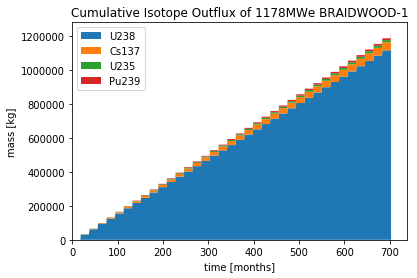

In [20]:
facility = '1178MWe BRAIDWOOD-1'
title = 'Cumulative Isotope Outflux of 1178MWe BRAIDWOOD-1'
analysis.plot_out_flux_cumulative(cur, facility,title)

Let's take a look at the total mass of spent nuclear fuel stored at the Nuclear Waste Repository.
To plot, use the `analysis.plot_in_flux_cumulative(cur, facility, title)` function. 
<div class="alert alert-info">
**Interactive Input**
<br/>
Using the table below, create the following variables.  Include appropriate comments.
</div>

| Variable | Value  | Purpose |
| -------- | ------ | ------- |
| `facility`      | `'NuclearRepository'` | facility of interest |
| `title`     | `'Cumulative Isotope Inventory of Repository'` | title of plot |


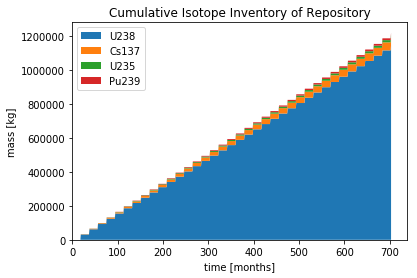

In [21]:
facility = 'NuclearRepository' # facility of interest
title  = 'Cumulative Isotope Inventory of Repository'  # title of plot

analysis.plot_in_flux_cumulative(cur, facility,title)

Now let's plot the cumulative mass of the spent nuclear fuel that is mined from the Uranium mine.
To plot the outflux of a facility, use the analysis.plot_out_flux_cumulative(cur,sender,plot title) function.

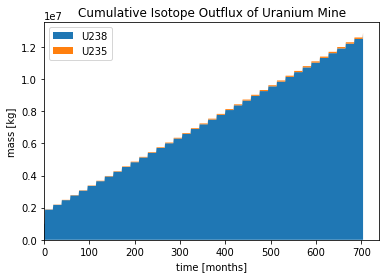

In [22]:
analysis.plot_out_flux_cumulative(cur, 'UraniumMine','Cumulative Isotope Outflux of Uranium Mine')


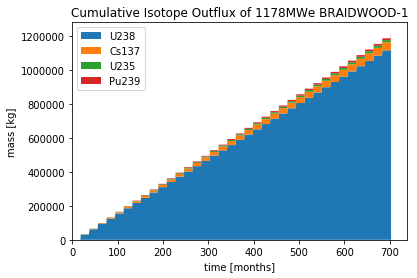

In [23]:
analysis.plot_out_flux_cumulative(cur, '1178MWe BRAIDWOOD-1','Cumulative Isotope Outflux of 1178MWe BRAIDWOOD-1')

Now let's plot the mass series and cumulative mass of the fresh nuclear fuel that is received by the of the 1178MWe BRAIDWOOD-1.

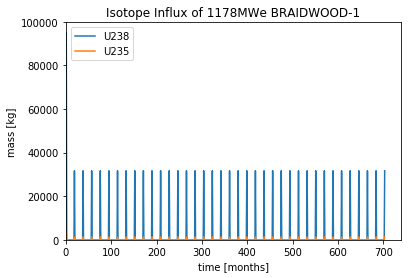

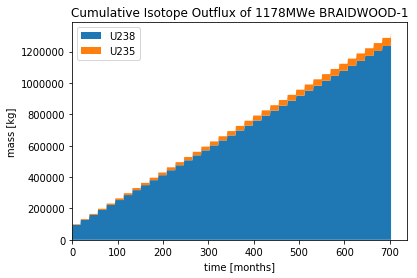

In [24]:
analysis.plot_in_flux(cur, '1178MWe BRAIDWOOD-1','Isotope Influx of 1178MWe BRAIDWOOD-1')
analysis.plot_in_flux_cumulative(cur, '1178MWe BRAIDWOOD-1','Cumulative Isotope Outflux of 1178MWe BRAIDWOOD-1')

In cyclus, facilities are defined by their `prototype_id`. For example if the simualtion had 20 different reactors, we could still find a certain one via its `prototype_id`.

<div class="alert alert-info">
**Interactive Input**
<br/>
In the cell below use type `facility = 'UraniumMine'` and then run the cell.
</div>

In [25]:
facility = 'UraniumMine'
print('The prototype_ids for' + ' ' + facility + ' ' +'' + 'are:')
analysis.prototype_id(cur, facility)

The prototype_ids for UraniumMine are:


['25']

We can also find the total amount [kg] of an isotope that was used/sent from a facility using the `total_isotope_used` function.
For example, if we wanted to find out how much $^{235}$U and $^{238}$U was mined from the Uranium Mine, we can call:

In [26]:
uranium_mined = analysis.total_isotope_used(cur, 'UraniumMine')
print("Total amount of U-235 mined:" + ' '  + str(uranium_mined['U235']) + ' ' + 'kg')
print("Total amount of U-238 mined:" + ' '  + str(uranium_mined['U238']) + ' ' + 'kg')


Total amount of U-235 mined: 91599.6350365 kg
Total amount of U-238 mined: 12791612.0438 kg


Let's say we wanted to see the composition of the spent nuclear fuel from the reactor. We could call `total_isotope_used` with `facility` = `'1178MWe BRAIDWOOD-1'` to find out!

<div class="alert alert-info">
**Interactive Input**
<br/>
Using the table below, create the following variable.  Include appropriate comments.
</div>

| Variable | Value  | Purpose |
| -------- | ------ | ------- |
| `facility`      | `'1178MWe BRAIDWOOD-1'` | facility of interest |


Text(0.5,1,'SNF mass composition')

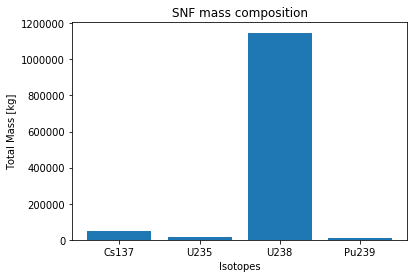

In [27]:
facility = '1178MWe BRAIDWOOD-1' # facility of interest
snf_comp = analysis.total_isotope_used(cur, facility)
snf_comp
isotopes = [item[0] for item in snf_comp.items()]
masses = [item[1] for item in snf_comp.items()]
plt.bar(isotopes,masses)
plt.xlabel('Isotopes')
plt.ylabel('Total Mass [kg]')
plt.title('SNF mass composition')

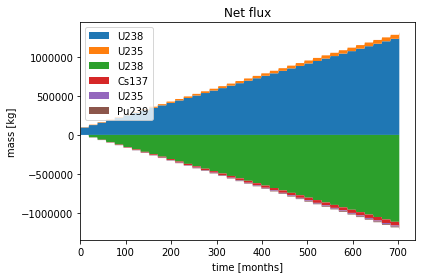

In [28]:
analysis.plot_net_flux_cumulative(cur,'1178MWe BRAIDWOOD-1','Net flux')


In [29]:
analysis.u_util_calc(cur)

array([ 0.        ,  0.11108108,  0.05554054,  0.03702703,  0.02777027,
        0.02221622,  0.01851351,  0.01586873,  0.01388514,  0.01234234,
        0.01110811,  0.01009828,  0.00925676,  0.0085447 ,  0.00793436,
        0.00740541,  0.00694257,  0.00653418,  0.00617117,  0.00807862,
        0.00793436,  0.00779516,  0.00766076,  0.00753092,  0.00740541,
        0.00728401,  0.00716652,  0.00705277,  0.00694257,  0.00683576,
        0.00673219,  0.00663171,  0.00653418,  0.00643948,  0.00634749,
        0.00625809,  0.00617117,  0.00608663,  0.00750548,  0.00740541,
        0.00730797,  0.00721306,  0.00712058,  0.00703045,  0.00694257,
        0.00685686,  0.00677324,  0.00669163,  0.00661197,  0.00653418,
        0.0064582 ,  0.00638397,  0.00631143,  0.00624051,  0.00617117,
        0.00610336,  0.00603702,  0.00716652,  0.00709028,  0.00701565,
        0.00694257,  0.00687099,  0.00680088,  0.00673219,  0.00666486,
        0.00659888,  0.00653418,  0.00647074,  0.00640852,  0.00

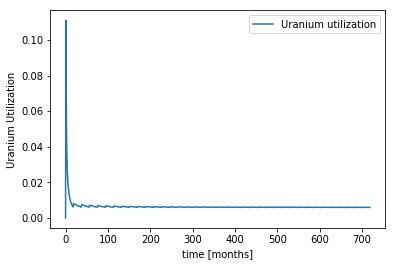

In [30]:
analysis.plot_uranium_utilization(cur)


## Decay heat
Using our `spent` fuel composition from above, lets see which isotope causes the most decay heat!

/Users/tyler/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: QAWarning: pyne.data is not yet QA compliant.
  return f(*args, **kwds)
/Users/tyler/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: QAWarning: pyne.material is not yet QA compliant.
  return f(*args, **kwds)


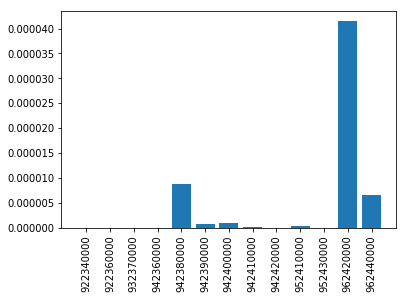

In [31]:
from pyne import data
from pyne.material import Material

data.decay_const('u238')

snf = analysis.total_isotope_used(cur,facility='1178MWe BRAIDWOOD-1')
snf_mass = np.sum(list(snf.values()))

lwr_snf_ma = Material(spent,snf_mass)
lwr_snf_ma = Material({'U234': 0.12, 
                    'U236': 4.18,
                    'Np237': 0.75,
                    '236Pu': 9.2E-6,
                    '238Pu': 0.22,
                    '239Pu': 5.28,
                    '240Pu': 2.17,
                    '241Pu': 1.02,
                    '242Pu': 0.35,
                    '241Am': 0.05,
                    '243Am': 0.09,
                    '242Cm': 4.9E-3,
                    '244Cm': 3.3E-2},
                   1000)

#print(snf_ma.comp)
#print(lwr_snf_ma.activity())
#print(lwr_snf_ma.decay_heat())
D=lwr_snf_ma.decay_heat()

import matplotlib.pylab as plt
plt.bar(range(len(D)), D.values(), align='center')
plt.xticks(range(len(D)), D.keys(), rotation='vertical')

plt.show()



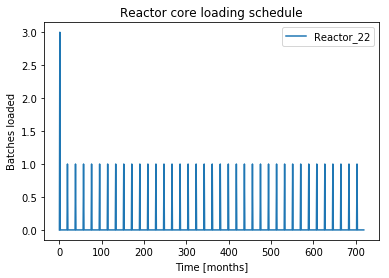

In [32]:
analysis.plot_reactor_events(cur,reactors = [])


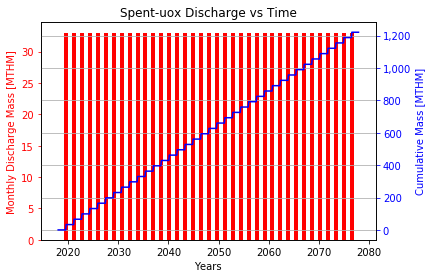

In [33]:
analysis.plot_commodity(cur,archetype='Sink',facility_commodity=['spent-uox'],is_outflux=False,is_cum=True)
from IPython.display import Image
Image(filename='cum_mass_spent-uoxdischarge.png')